# Efeitos de Segregação e Tensão em Poços Quânticos de InGaAs/GaAs

## Bibliotecas utilizadas

In [1]:
# third-party
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# locals
from core.constantes import *
from core.utilidades import *
from core.database import *

## Configurações gráficas

In [2]:
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('mestrado')

## Configurações do sistema

São 4 poços de InGaAs/GaAs com a fração de In pretendida $x_0=0{,}14$.

Os poços eram de 10, 15, 21 e 28 monocamadas.

In [3]:
N = 2048  # número de pontos da malha espacial
T = 77.0  # temperatura da PL em K
x0 = 0.14  # fração pretendida
monocamadas = [10, 15, 21, 28]

## Funções úteis

In [4]:
def interpola_concentracao(x_total, tamanho_sistema, N):
    metade = tamanho_sistema / 2.0
    z_temp = np.linspace(- metade, metade, len(x_total))
    z_ang = np.linspace(- metade, metade, N)
    f1 = interp1d(z_temp, x_total, kind='nearest')
    x_total = f1(z_ang)
    return z_ang, x_total


def in_segregacao(x0, R, n, N=None, r=1.0):
    if N:
        return r * x0 * (1 - R ** N) * R ** (n - N)
    return r * x0 * (1 - R ** n)


def x_grid(mc, x0, R):
    i = 0
    x_grid = []
    while True:
        i += 1
        if i > mc:
            in_x = in_segregacao(x0, R, i, mc)
        else:
            in_x = in_segregacao(x0, R, i)
        if in_x < 0.0001:
            break
        x_grid.append(in_x)
    return x_grid


def calcula_pl(z_ang, perfil_liga, tensao=False, CBO=0.67, VBO=0.33):
    me = np.array([a.me_g for a in perfil_liga])
    mhh = np.array([a.mhh_z for a in perfil_liga])
    gap = np.array([a.gap_g(T) for a in perfil_liga])
    vbo = np.array([a.vbo for a in perfil_liga])  
    Vv = vbo[0] - vbo
    Vc = gap - gap[0] + (vbo[0] - vbo)
    if tensao:
        ac = np.array([a.ac for a in perfil_liga])
        av = np.array([a.av for a in perfil_liga])
        b = np.array([a.b for a in perfil_liga])
        a0 = np.array([a.alc(T) for a in perfil_liga])
        c11 = np.array([a.c11 for a in perfil_liga])
        c12 = np.array([a.c12 for a in perfil_liga])
        exx = eyy = (a0[0] - a0) / a0
        ezz = - 2.0 * (c12 / c11) * exx
        Tr = exx + eyy + ezz
        nTr = exx + eyy - 2.0 * ezz
        ajuste_c = ac * Tr
        ajuste_v = av * Tr - (b / 2.0) * nTr
        gap = gap + ajuste_c + ajuste_v
        Vv = Vv - ajuste_v
        Vc = Vc + ajuste_c
    
    # ajusta o zero no mínimo do poço
    Vv_red = Vv - np.min(Vv)
    Vc_red = Vc - np.min(Vc)
    # valores em unidades atômicas
    Vc_au = Vc_red / au2ev
    Vv_au = Vv_red / au2ev
    z_au = z_ang / au2ang
    # calcula o nível fundamental nmax=1 facilita no tempo
    res_e = interacao_inversa(z_au, Vc_au, me, nmax=1)  # eletron - condução
    res_hh = interacao_inversa(z_au, Vv_au, mhh, nmax=1)  # buraco - valência
    # calcula PL subtraindo 0.007 da energia do exciton
    eigen_e = res_e['autovalores'][0] * au2ev # em eV
    eigen_hh = res_hh['autovalores'][0] * au2ev # em eV
    # o gap usado é o menor dentro do poço
    GAP = np.min(gap)
    return GAP + eigen_e + eigen_hh - 0.007

# Cálculo da PL

## PL obtida experimentalmente

In [5]:
pl_experimental = {
    10: 1.45337,
    15: 1.42287,
    21: 1.39625,
    28: 1.37674
}

## PL simples

Valor da PL supondo poço quântico simples.

In [6]:
pl_numerica_simples = {}

for mc in monocamadas:
    # concentracao em cada camada do poco
    x_poco = [x0] * mc
    # utilizando barreiras de 250 angstroms
    x_barreira = [0.0] * int(250.0 / InGaAs(0.0).alc(T))
    # concentração 
    x_total = x_barreira + x_poco + x_barreira
    # considerando que o parametro de rede muda em cada camada
    tamanho_sistema = np.sum([InGaAs(x).alc(T) for x in x_total])
    # interpola concentração ponto a ponto para N pontos
    z_ang, x_total = interpola_concentracao(x_total, tamanho_sistema, N)
    perfil_liga = [InGaAs(x) for x in x_total]
    # cálculo da PL
    pl = calcula_pl(z_ang, perfil_liga)
    pl_numerica_simples[mc] = pl
    print("MC: {} monocamadas, PL: {:.6f} eV".format(mc, pl))

MC: 10 monocamadas, PL: 1.382127 eV
MC: 15 monocamadas, PL: 1.342807 eV
MC: 21 monocamadas, PL: 1.321422 eV
MC: 28 monocamadas, PL: 1.309317 eV


[]

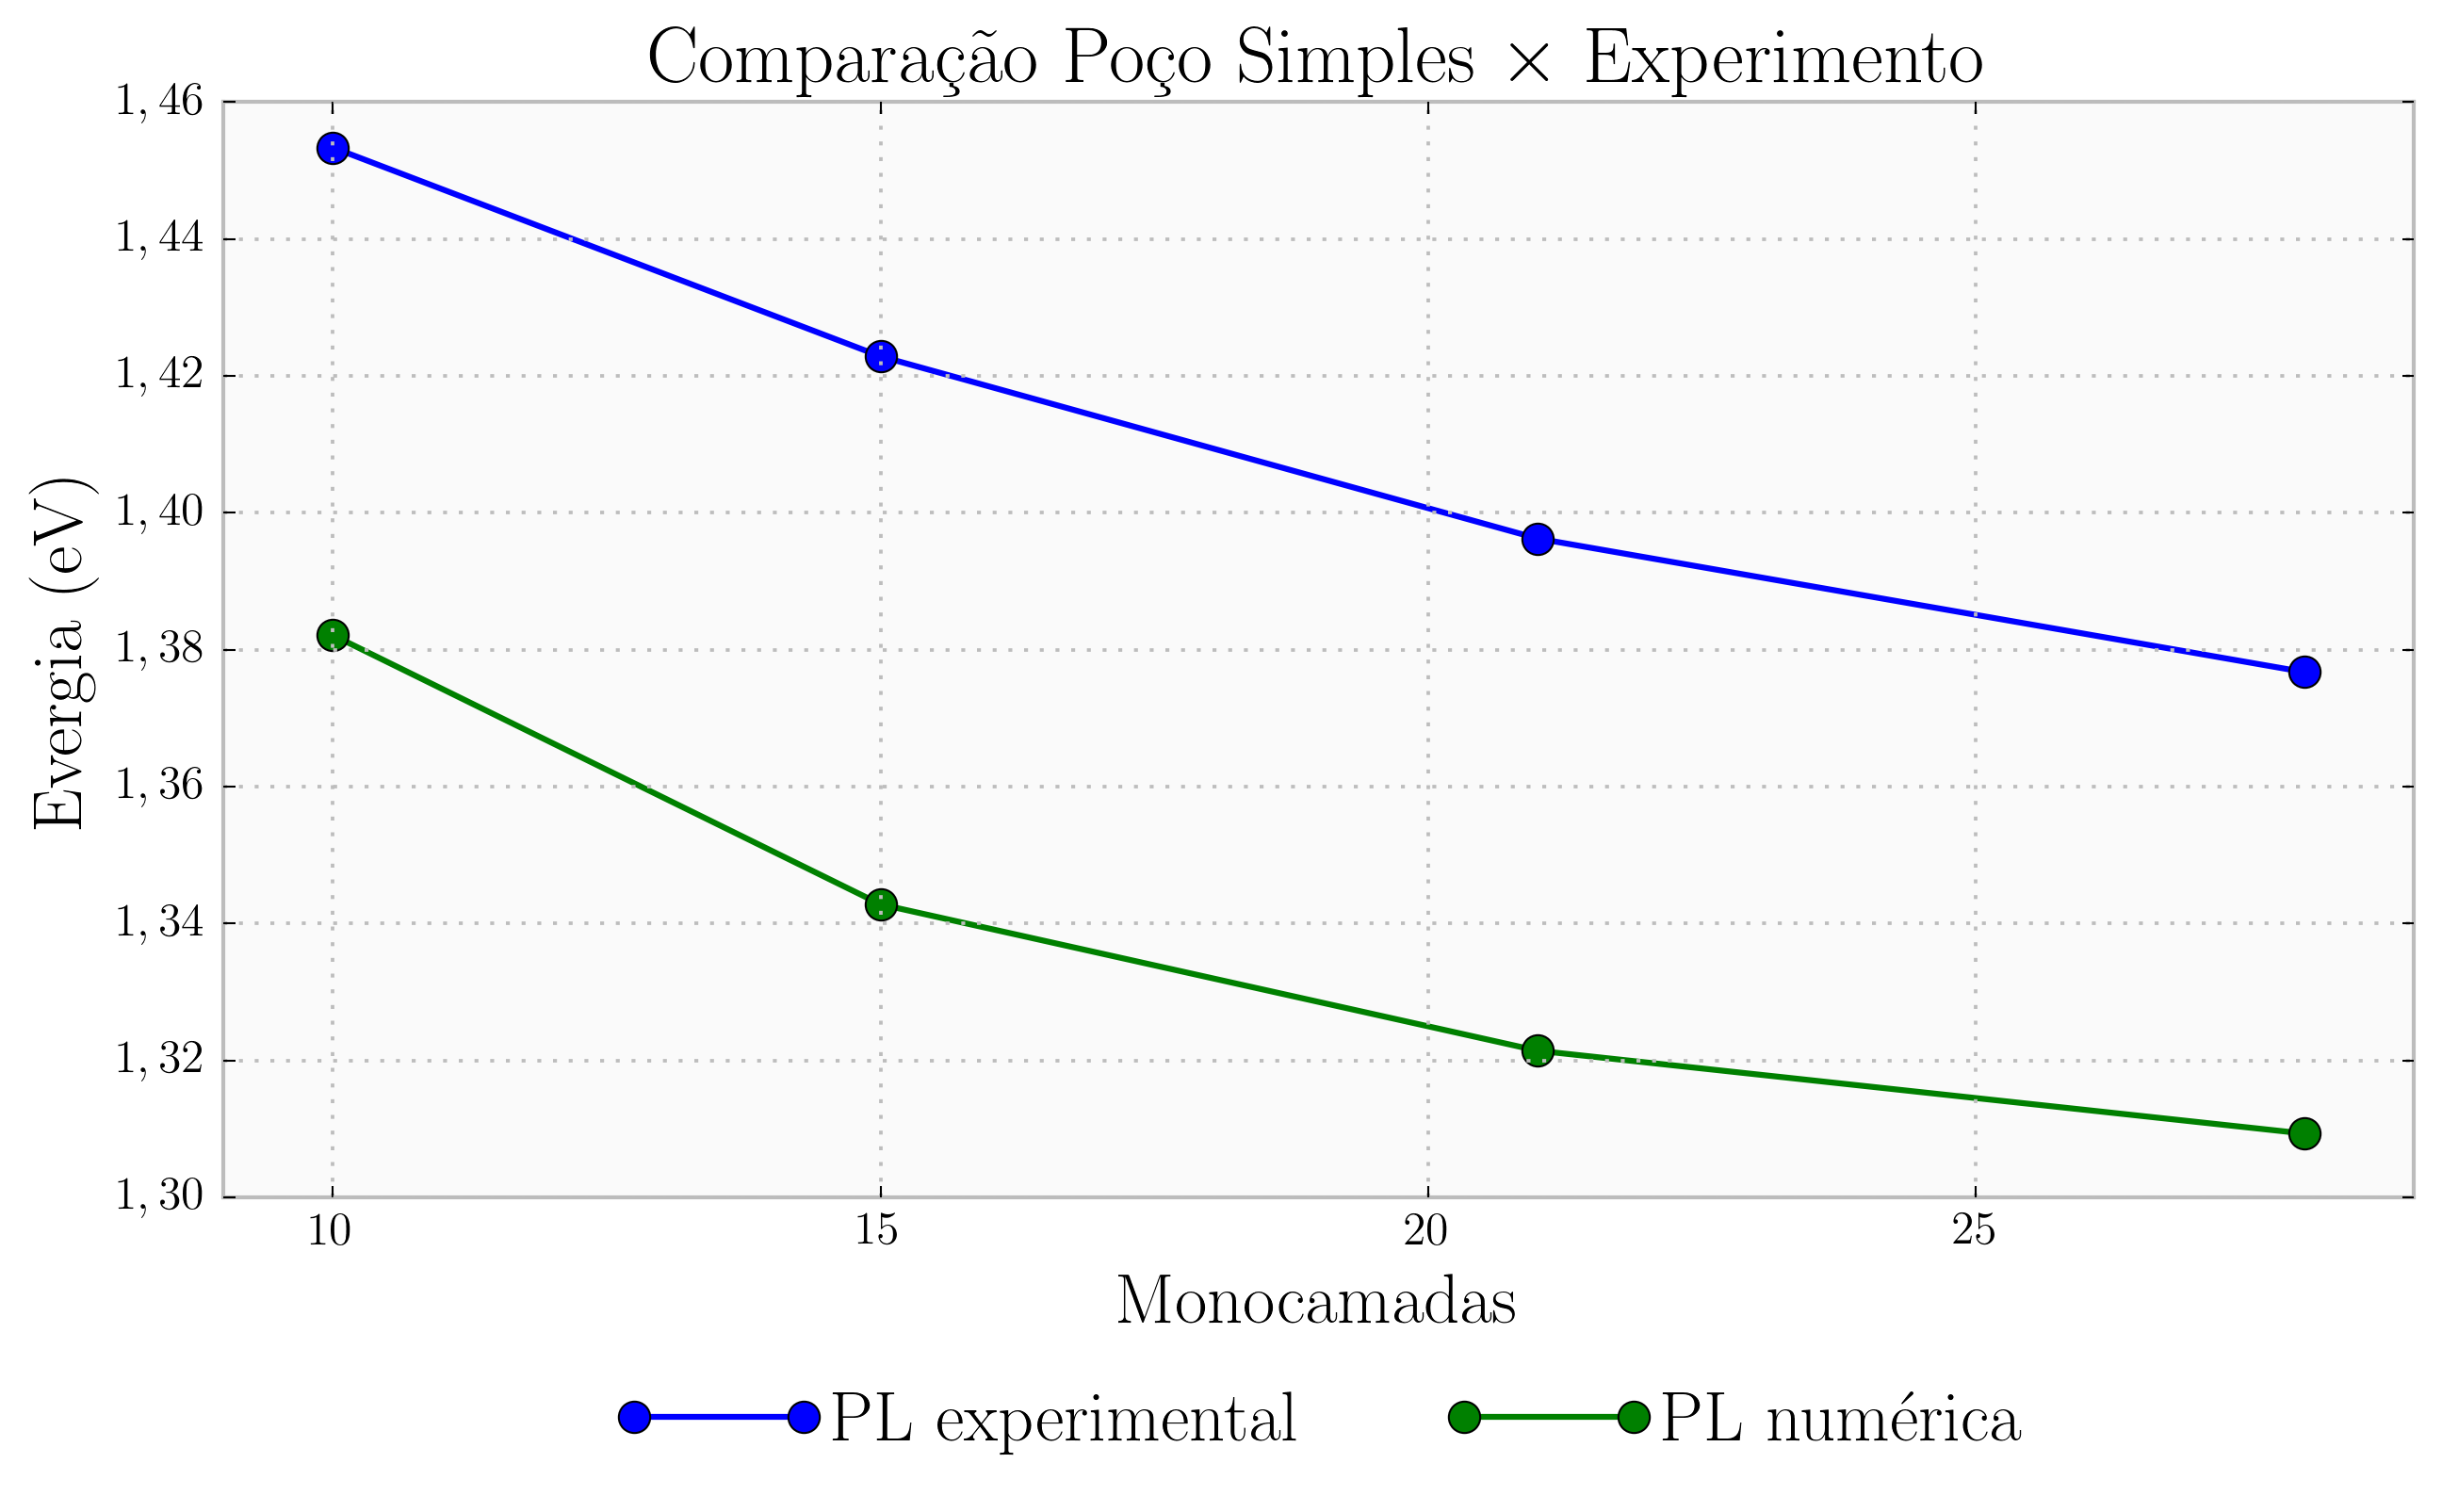

In [7]:
pl_exp = [pl_experimental[mc] for mc in monocamadas]
pl_num = [pl_numerica_simples[mc] for mc in monocamadas]

fig, ax = plt.subplots()
ax.plot(monocamadas, pl_exp, label=r"PL experimental", marker='o')
ax.plot(monocamadas, pl_num, label=r"PL num\'{e}rica", marker='o')
ax.grid(True)
ax.set_xlabel('Monocamadas')
ax.set_ylabel('Evergia (eV)')
ax.title.set_text(r"Compara\c{c}\~{a}o Po\c{c}o Simples $\times$ Experimento")
ax.set_xlim([9, 29])
plt.legend(loc='upper center', bbox_to_anchor=(0.50, -0.12),  shadow=True, ncol=2)
plt.plot()

## PL com efeitos de tensão

In [8]:
pl_numerica_tensao = {}

for mc in monocamadas:
    # concentracao em cada camada do poco
    x_poco = [x0] * mc
    # utilizando barreiras de 250 angstroms
    x_barreira = [0.0] * int(250.0 / InGaAs(0.0).alc(T))
    # concentração 
    x_total = x_barreira + x_poco + x_barreira
    # considerando que o parametro de rede muda em cada camada
    tamanho_sistema = np.sum([InGaAs(x).alc(T) for x in x_total])
    # interpola concentração ponto a ponto para N pontos
    z_ang, x_total = interpola_concentracao(x_total, tamanho_sistema, N)
    perfil_liga = [InGaAs(x) for x in x_total]
    # cálculo da PL
    pl = calcula_pl(z_ang, perfil_liga, tensao=True)
    pl_numerica_tensao[mc] = pl
    print("MC: {} monocamadas, PL: {:.6f} eV".format(mc, pl))

MC: 10 monocamadas, PL: 1.420585 eV
MC: 15 monocamadas, PL: 1.387698 eV
MC: 21 monocamadas, PL: 1.368922 eV
MC: 28 monocamadas, PL: 1.357959 eV


[]

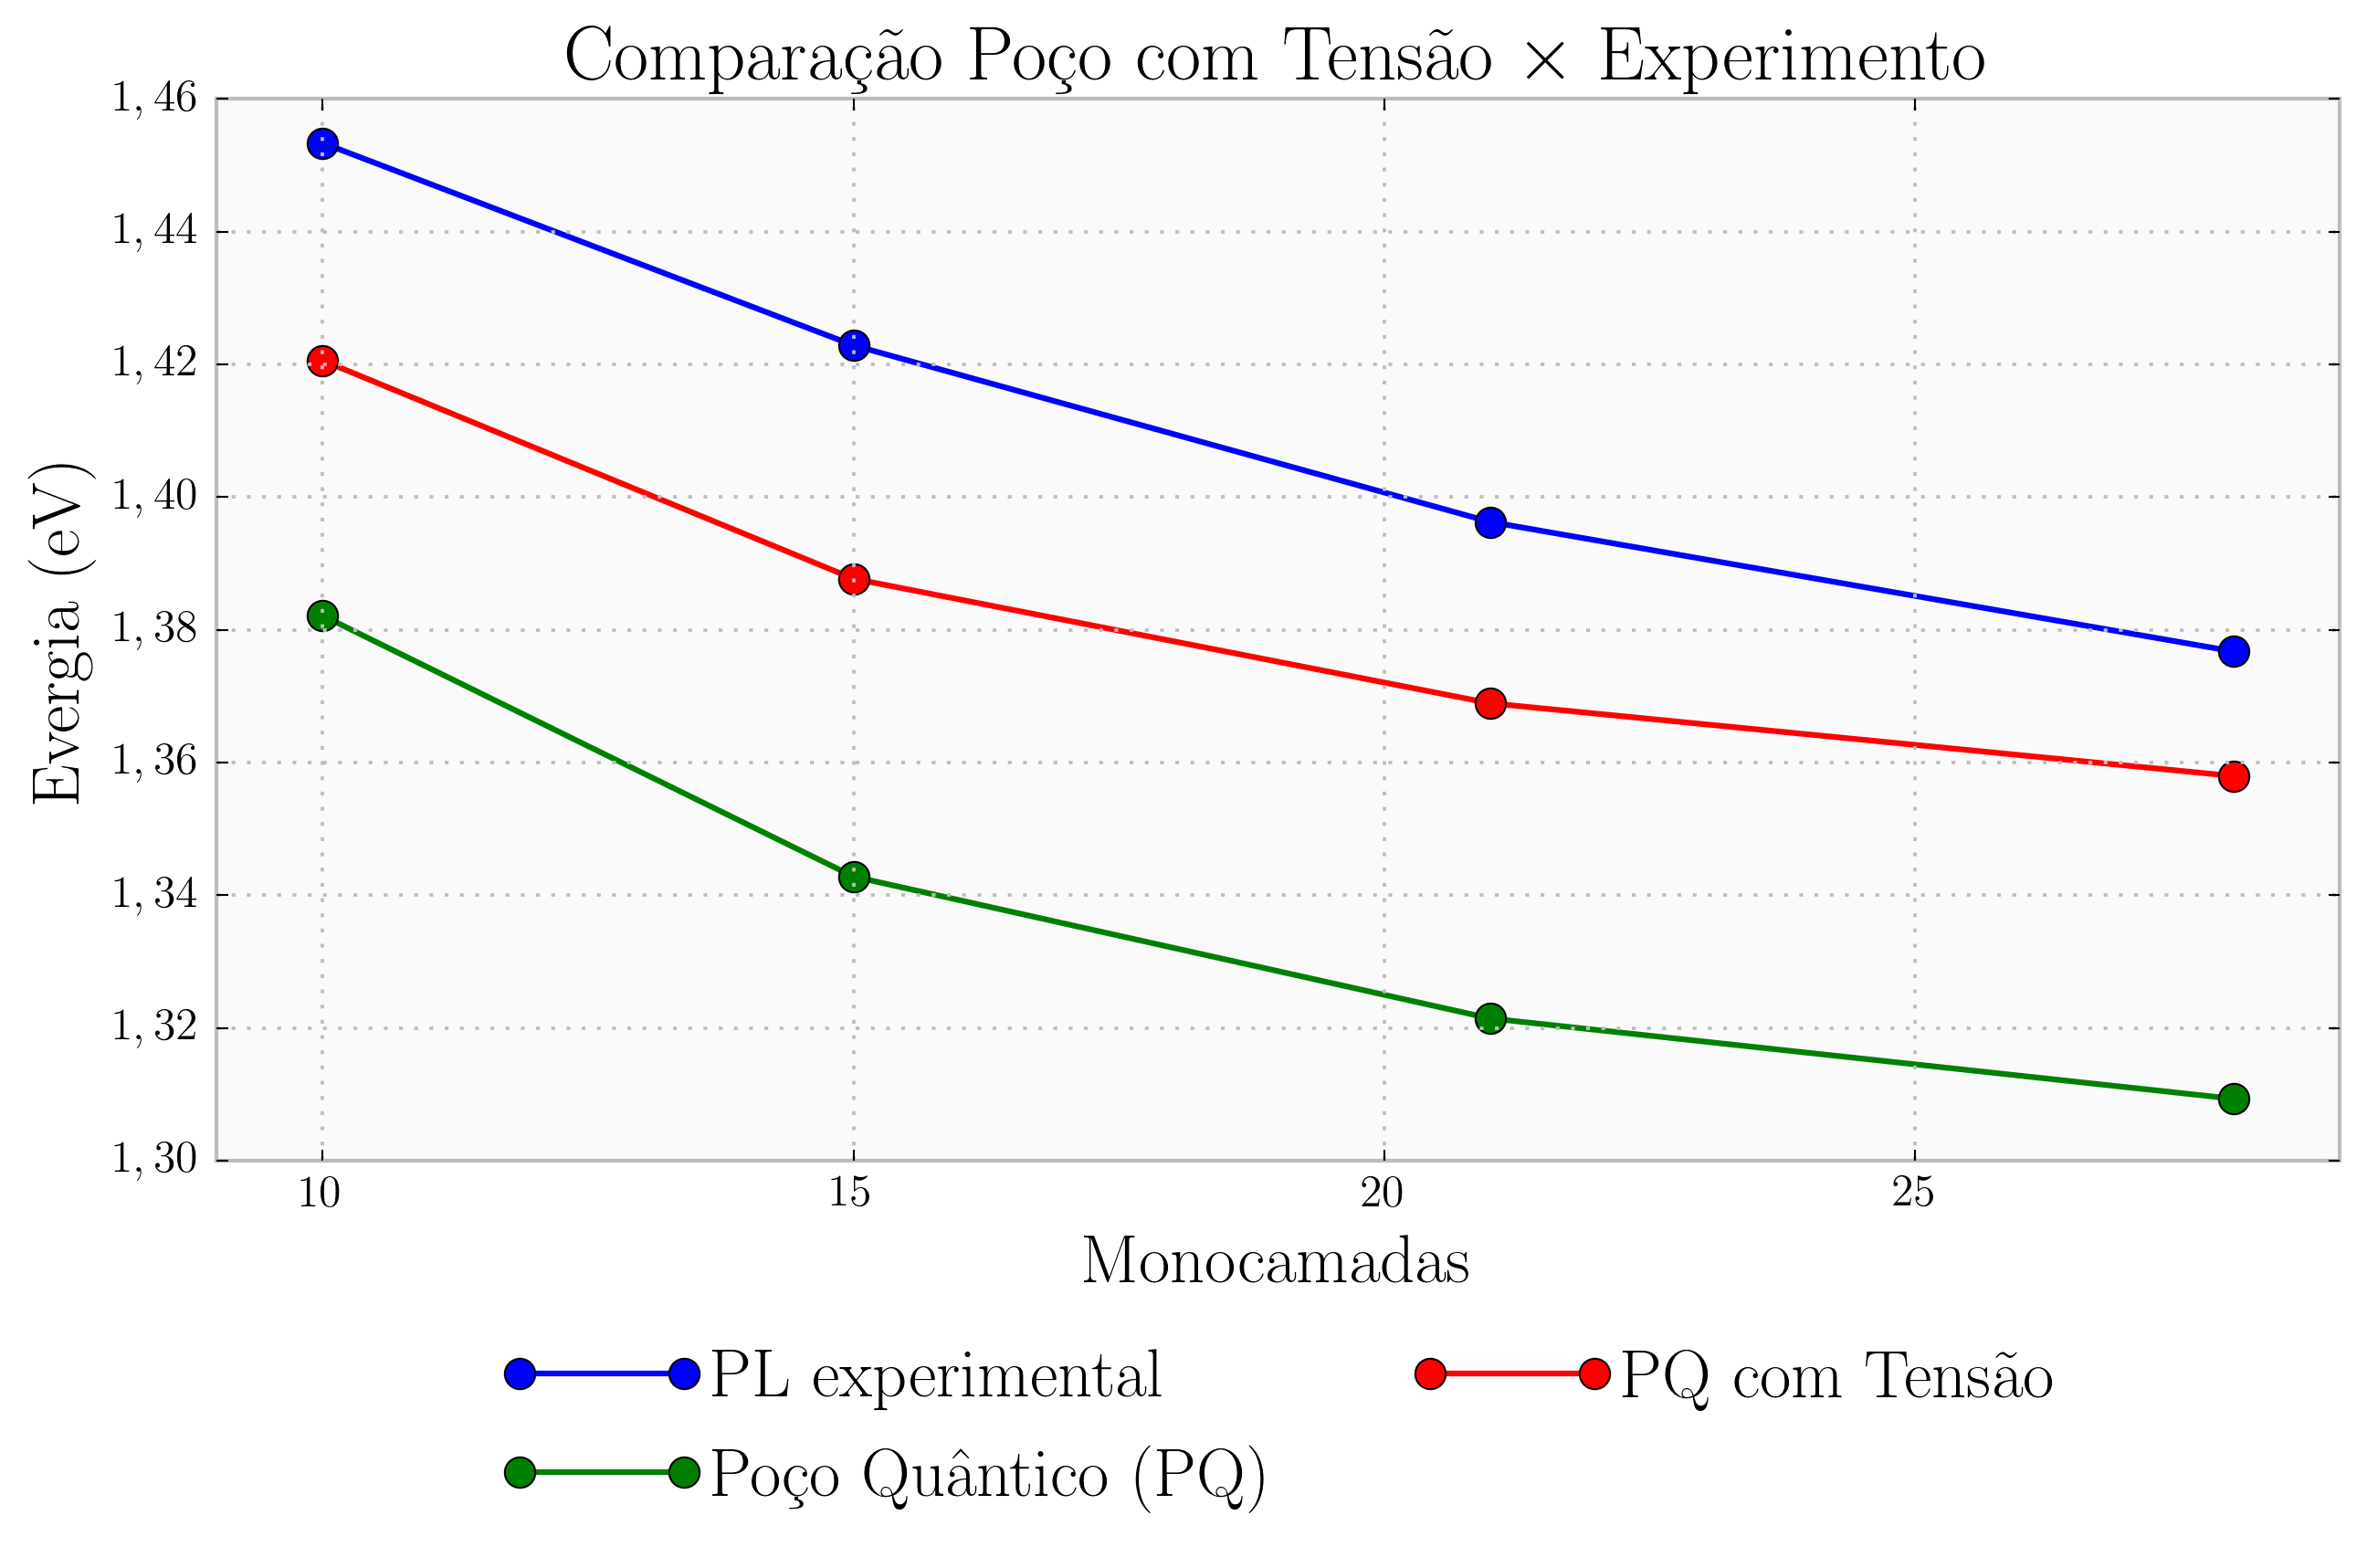

In [9]:
pl_exp = [pl_experimental[mc] for mc in monocamadas]
pl_num_1 = [pl_numerica_simples[mc] for mc in monocamadas]
pl_num_2 = [pl_numerica_tensao[mc] for mc in monocamadas]

fig, ax = plt.subplots()
ax.plot(monocamadas, pl_exp, label=r"PL experimental", marker='o')
ax.plot(monocamadas, pl_num_1, label=r"Po\c{c}o Qu\^{a}ntico (PQ)", marker='o')
ax.plot(monocamadas, pl_num_2, label=r"PQ com Tens\~{a}o", marker='o')

ax.grid(True)
ax.set_xlabel('Monocamadas')
ax.set_ylabel('Evergia (eV)')
ax.title.set_text(r"Compara\c{c}\~{a}o Po\c{c}o com Tens\~{a}o $\times$ Experimento")
ax.set_xlim([9, 29])
plt.legend(loc='upper center', bbox_to_anchor=(0.50, -0.12),  shadow=True, ncol=2)
plt.plot()

## PL com efeitos de tensão e segregação

In [10]:
pl_numerica_tensao_segregacao = {}

for mc in monocamadas:
    # concentracao em cada camada do poco
    x_poco = x_grid(mc, x0, R=0.867)
#     x_poco = x_grid(mc, x0, R=0.90)
    # utilizando barreiras de 250 angstroms
    x_barreira = [0.0] * int(250.0 / InGaAs(0.0).alc(T))
    # concentração 
    x_total = x_barreira + x_poco + x_barreira
    # considerando que o parametro de rede muda em cada camada
    tamanho_sistema = np.sum([InGaAs(x).alc(T) for x in x_total])
    # interpola concentração ponto a ponto para N pontos
    z_ang, x_total = interpola_concentracao(x_total, tamanho_sistema, N)
    perfil_liga = [InGaAs(x) for x in x_total]
    # cálculo da PL
    pl = calcula_pl(z_ang, perfil_liga, tensao=True)
    pl_numerica_tensao_segregacao[mc] = pl
    print("MC: {} monocamadas, PL: {:.6f} eV".format(mc, pl))

MC: 10 monocamadas, PL: 1.460471 eV
MC: 15 monocamadas, PL: 1.427168 eV
MC: 21 monocamadas, PL: 1.399239 eV
MC: 28 monocamadas, PL: 1.378505 eV


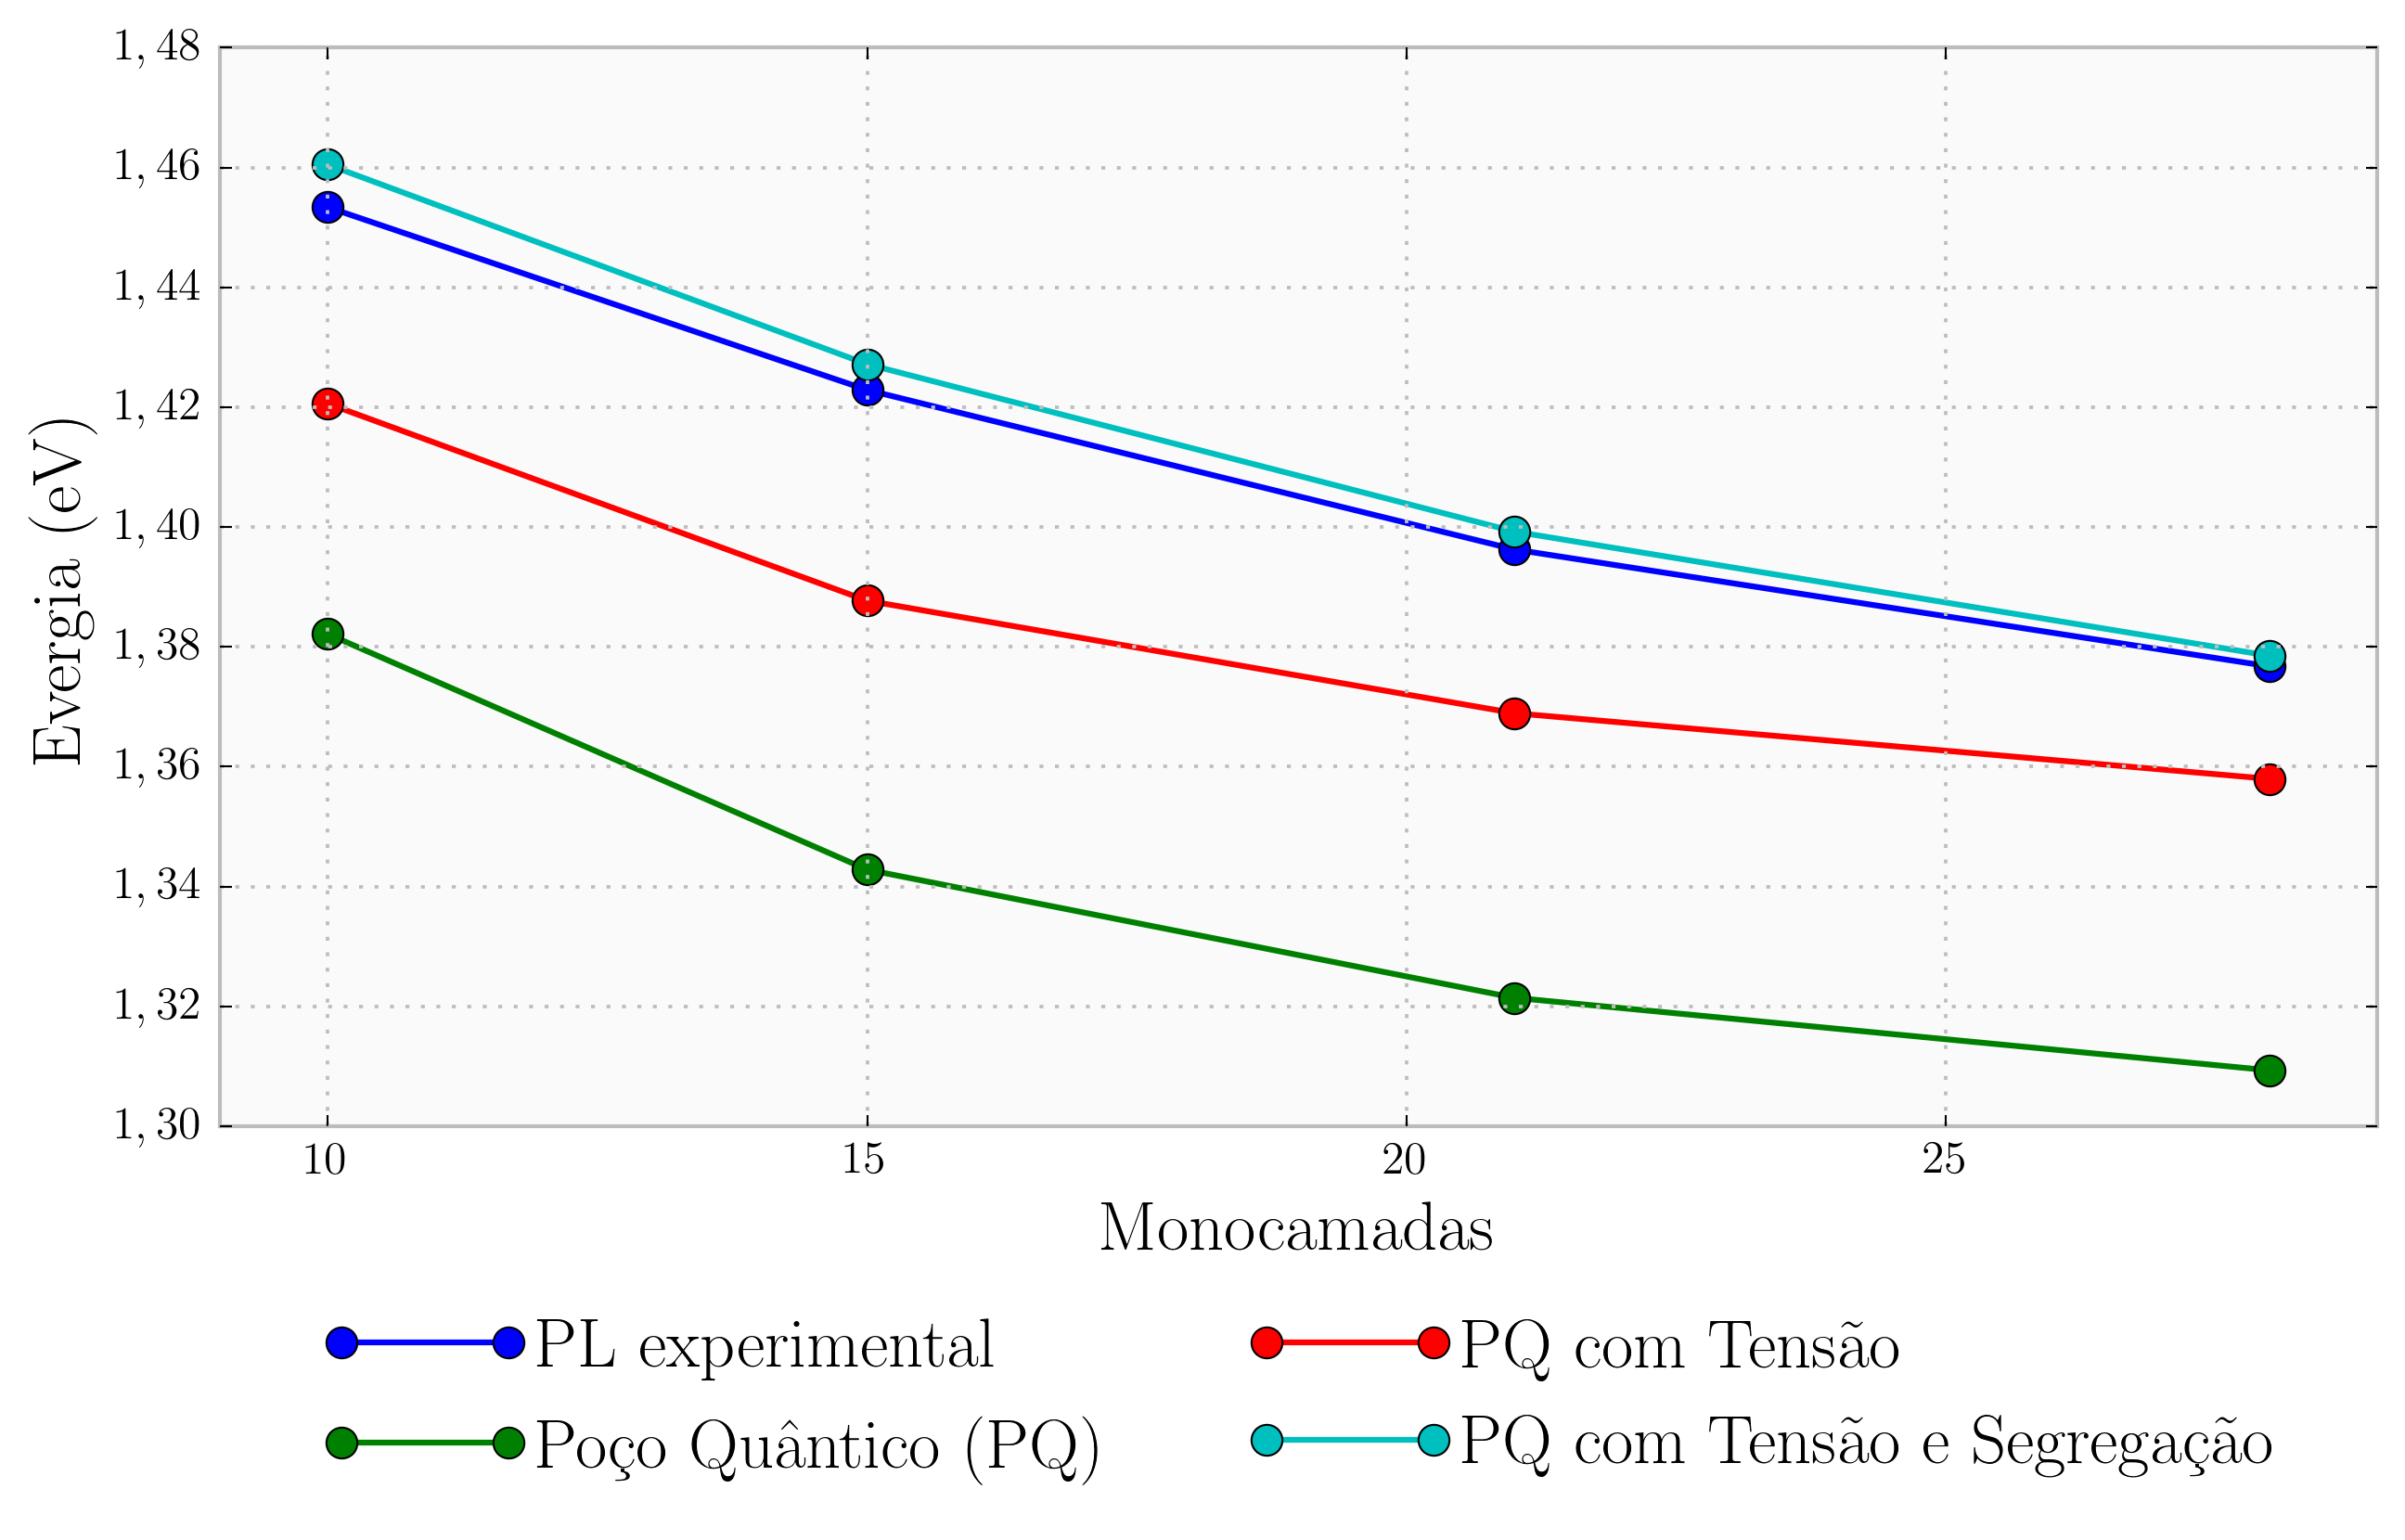

In [11]:
pl_exp = [pl_experimental[mc] for mc in monocamadas]
pl_num_1 = [pl_numerica_simples[mc] for mc in monocamadas]
pl_num_2 = [pl_numerica_tensao[mc] for mc in monocamadas]
pl_num_3 = [pl_numerica_tensao_segregacao[mc] for mc in monocamadas]

fig, ax = plt.subplots()
ax.plot(monocamadas, pl_exp, label=r"PL experimental", marker='o')
ax.plot(monocamadas, pl_num_1, label=r"Po\c{c}o Qu\^{a}ntico (PQ)", marker='o')
ax.plot(monocamadas, pl_num_2, label=r"PQ com Tens\~{a}o", marker='o')
ax.plot(monocamadas, pl_num_3, label=r"PQ com Tens\~{a}o e Segrega\c{c}\~{a}o", marker='o')

ax.grid(True)
ax.set_xlabel('Monocamadas')
ax.set_ylabel('Evergia (eV)')
# ax.title.set_text(r"Compara\c{c}\~{a}o Po\c{c}o com Tens\~{a}o e Segrega\c{c}\~{a}o $\times$ Experimento")
ax.set_xlim([9, 29])
plt.legend(loc='upper center', bbox_to_anchor=(0.50, -0.12),  shadow=True, ncol=2)
plt.savefig('figuras/ingaas_pl_77_comparacao.png', bbox_inches='tight')